# Homework 7: Neural Network

Note: To run this notebook. You should change runtime type to GPU by: go to Runtime -> Change runtime type -> GPU

In lecture 7's video, we have shown you how to use Neural Network to classify handwritten digits on the MNIST dataset. In this notebook, we will go into the details. We also discover components that we have not talked about in the video.

Import some libraries and packages

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

Download dataset

In [ ]:
trainset = torchvision.datasets.MNIST('./data', download=True, train=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST('./data', download=True, train=False, transform=transforms.ToTensor())

Check an image and its label

Label:  4
Image shape:  torch.Size([1, 28, 28])


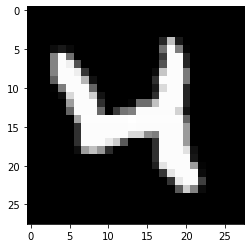

In [ ]:
img, label = trainset[20]
print('Label: ', label)
print('Image shape: ', img.shape)
plt.imshow(img[0], cmap='gray')

Pytorch provides DataLoader to efficiently load data from dataset for both training and testing. For more details about the configurations, you can refer to https://pytorch.org/docs/stable/data.html

In [ ]:
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

An Neural Network has layers. To create a layer you can use `nn.Linear`. Let examine one layer.

Here we create a layer which has 4 neurons and 2 inputs. Matrix of weight ($W$) has shape of 4x2, $W \in \mathbb{R}^{4*2}$. The bias vector of neurons is b, $b \in \mathbb{R}^{4}$. Assuming the input $x \in \mathbb{R}^{b*2}$, where is the batch size. Then the output of this layer is:
$$ y = xW^T + b$$

**Task 1**: Fill in the code to calculate the output of a layer for given input. **(1 point)**

*Hints*: for matrix multiplication in pytorch, you can use `torch.matmul`. 

In [ ]:
a_layer = nn.Linear(2, 4)           # we create a layer
print("transposed weight: ", a_layer.weight.T)   # print the weight of the layer
print("bias: ", a_layer.bias)       # print the bias of the layer
input = torch.rand((3, 2))          # we create a dummy input
print('input: ', input)
# your code here      
output = torch.matmul(input, a_layer.weight.T) + a_layer.bias
print('output: ', output)          

transposed weight:  tensor([[-0.0057,  0.0601, -0.1673,  0.2628],
        [ 0.1355,  0.6030, -0.4148, -0.0163]], grad_fn=<PermuteBackward0>)
bias:  Parameter containing:
tensor([-0.5350,  0.4347, -0.3199,  0.1779], requires_grad=True)
input:  tensor([[0.2511, 0.0492],
        [0.3959, 0.0221],
        [0.9197, 0.2503]])
output:  tensor([[-0.5298,  0.4794, -0.3823,  0.2431],
        [-0.5343,  0.4718, -0.3953,  0.2816],
        [-0.5064,  0.6409, -0.5775,  0.4155]], grad_fn=<AddBackward0>)


**Task 2**: We implement below architecture in the video. It works quite well. Let's try to add the third hidden layer and keep other layers. **(1 point)**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 120)  # first hidden layer
        self.fc2 = nn.Linear(120, 84)     # second hidden layer
        # your code here
        self.additional_layer = nn.Linear(84, 84)
        self.fc3 = nn.Linear(84, 10)      # output layer

    def forward(self, x):
        x = torch.flatten(x, 1)   # flatten all dimensions except batch
        x = F.relu(self.fc1(x))   # compute output of first hidden layer + activation function
        x = F.relu(self.fc2(x))   # compute output of second hiddlen layer + activation function
        # your code here
        x = F.relu(self.additional_layer(x))
        x = self.fc3(x)           # compute output
        return x                  # return output

model = Net()

We have used `CrossEntropyLoss` function to calculate loss. It is equivalent to the combination of `LogSoftmax` and `NLLLoss`. We have not talked about these two functions. They are two commonly used functions in classification problems.

In the output layer, we don't use any activation function. To get the final prediction, we just need to chooose the maximum output. However, you should use softmax to get the estimated probabilities. Output of softmax function are:


<center>$\sigma(z)_{i} = \frac{e^{z_{i}}}{\sum_{j=1}^{C}e^{z_{j}}} $ for $i = 1, ..., C$ and $\textbf{z} = \{z_1, z_2, ..., z_C\}$</center>


where $C$ is number of classes, $\textbf{z}$ is the output of network.

**Task 3**: You are asked to implement softmax function **(1 point)**

Hints: to calculate the exponential of input elements you can use *exp()* function. For example, `z.exp()`

In [ ]:
def softmax(z):
  # your code here
  output = z.exp() / z.exp().sum(-1).unsqueeze(-1)
  return output

In [ ]:
def log_softmax(z):
  return softmax(z).log()

**Task 4**: You are asked to implement Negative Log Likelihood as follow: **(1 point)**
<center>$l_n = -x_n y_n$ where $\textbf{x}$ is prediction, $\textbf{y}$ is target in form of one-hot vector, </center> 

Note: in above equation $\textbf{y}$ is an one-hot vector. Meanwhile, the below `target` is an integer value.

In [ ]:
def nll(preds, target):
  # your code here
  l = -preds[range(preds.shape[0]), target]
  return l

In [ ]:
def cross_entropy_loss(z, target):
  return nll(log_softmax(z), target).mean()

loss_function = nn.CrossEntropyLoss()
z = torch.rand((3, 10))
target = torch.tensor([0, 5, 9], dtype=torch.long)
print(cross_entropy_loss(z, target))
print(loss_function(z, target))

# assert cross_entropy_loss(z, target) == loss_function(z, target), 'The two above task are not correct!'

tensor(2.4306)
tensor(2.4306)


We constraint the model not too complex by using regularization. One way of doing that is putting constraint to weights of models. For example, in ridge regularization, we add L2 loss term to the loss function:
$$J(\theta) = CrossEntropyLoss(\theta) + \alpha \sum\limits_{i=1}^n\theta_{i}^2$$
where $\theta$ is model's parameters (not including bias), $\alpha$ is a hyper-paramter to control degree of regularization.

**Task 5**: You are asked to implement loss function composed of cross entropy loss and L2 regularization loss. **(1 point)**

Hints: use `model.parameters()`

In [ ]:
def CEloss_with_l2(z, target, model, alpha):
  CE_loss = cross_entropy_loss(z, target)
  # Your code here
  L2_loss = 0
  for p in model.parameters():
    L2_loss = L2_loss + alpha * p.square().sum()
  loss = CE_loss + L2_loss
  return loss

CEloss_with_l2(torch.rand(2, 10), torch.tensor([2, 3], dtype=torch.long), model, 0.001)

tensor(2.0752, grad_fn=<AddBackward0>)

**Task 6**: Similarly, let implement loss function composed of cross entropy loss and L1 regularization **(1 point)**

In [ ]:
def CEloss_with_l1(z, target, model, alpha):
  # Your code here
  CE_loss = cross_entropy_loss(z, target)
  L1_loss = 0
  for p in model.parameters():
    L1_loss = L1_loss + alpha * p.abs().sum()
  loss = CE_loss + L1_loss 
  return loss

CEloss_with_l1(torch.rand(2, 10), torch.tensor([2, 3], dtype=torch.long), model, 0.001)

tensor(4.9326, grad_fn=<AddBackward0>)

For using L2 regularization in Pytorch, you can set `weight_decay` property of optimizer. Here, we use the default value `weight_decay=0`.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

**Task 7:** Below code is the procedure to train and evaluate the trained model. We put more comments so you can better understand each line of code. We also put redundant lines of code in the `evaluate` section. Your task is to find all redundant code and comment them out. (**2 points**)

In [ ]:
model.cuda()    # move model to GPU for faster computation in parallel
n_epochs = 2    # you should change to larger value
for epoch in range(n_epochs):
  print(f'Epoch {epoch}- Training... ')
  for batch_idx, (imgs, labels) in enumerate(tqdm(train_dataloader)):
    imgs = imgs.cuda()      # move images to GPU
    labels = labels.cuda()  # move labels to GPU
    optimizer.zero_grad()   # by default, Pytorch's optimizer retains gradient after apply Gradient Descent. We need to call this function to clear gradients explicitly.
    preds = model(imgs)     # pass batch of data through the model. 
    loss = loss_function(preds, labels)   # compute loss 
    loss.backward()         # compute gradient by running backpropgation algorithm
    optimizer.step()        # apply Gradient Descent
  
  # evaluate 
  print(f'Epoch {epoch}- Evaluating... ')
  total_correct = 0
  total = len(testset)
  for batch_indx, (imgs, labels) in enumerate(tqdm(test_dataloader)):
    imgs = imgs.cuda()
    labels = labels.cuda()
    preds = model(imgs).argmax(axis=-1)
    # loss = loss_function(preds, labels)
    # loss.backward()
    n_correct = torch.sum(preds == labels)
    total_correct += n_correct.item()
  
  print("Accuracy: ", total_correct/total)

Epoch 0- Training... 


100%|██████████| 3750/3750 [00:21<00:00, 172.62it/s]


Epoch 0- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 204.64it/s]


Accuracy:  0.8992
Epoch 1- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 240.80it/s]


Epoch 1- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 160.60it/s]

Accuracy:  0.9217


**Task 8**: In this task, you are asked to use the last trained model to make a prediction of an image on test set. You also need to calculate the confident score of that prediction using softmax function. **(2 points)**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Prediction: 7 - confident score: 0.9835746884346008


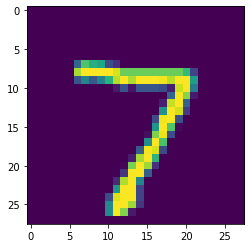

In [ ]:
img, label = testset[0]   # you can change the index
input_tensor = torch.tensor(img).cuda()   # convert image to tensor to be able to pass through model, and move the image to GPU
output = model(input_tensor)
# your code here
value = output.argmax()
confident_score = softmax(output)[0, value]
print(f"Prediction: {value} - confident score: {confident_score}")
plt.imshow(img[0])